In [ ]:
import os # operating system interfaces, to manipulate paths
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

## 1. Loading the competition data

In [ ]:
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
submission = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

**Preview dataset**

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
submission.head()



*   There were 3029 RNA sequeces.
*   Experiments were done using first 68 values of the 107-length sequence.
-   These 3069 (107-base) were split into 2400 train + 629 test with filters being applied to choose the 629 samples. The filters are as follows:



---

1. Minimum value across all 5 conditions must be greater than -0.5.
2. Mean signal/noise across all 5 conditions must be greater than 1.0. [Signal/noise is defined as mean( measurement value over 68 nts )/mean( statistical error in measurement value over 68 nts)]
3. To help ensure sequence diversity, the resulting sequences were clustered into clusters with less than 50% sequence similarity, and the 629 test set sequences were chosen from clusters with 3 or fewer members. That is, any sequence in the test set should be sequence similar to at most 2 other sequences.

---
And as per the instructions, Private LB scoring will be made on 130-base 3005 sequences where the measurement is done on the basis of first 91 bases.

> Note that, the above filters won't be applied to these 3005 samples.

# Understading our Train/Test set

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
print(train['sequence'].apply(lambda x: len(x)).value_counts())  # all the sequences have 107 bases
print(train['structure'].apply(lambda x: len(x)).value_counts())  # all the structures have 107 bases
print(train['predicted_loop_type'].apply(lambda x: len(x)).value_counts())  # all the structures have 107 bases

And reactivity_error,	deg_error_Mg_pH10,	deg_error_pH10,	deg_error_Mg_50C,	deg_error_50C,	reactivity,	deg_Mg_pH10,	deg_pH10,	deg_Mg_50C,	deg_50C; these columns have length 68 as its measured on first 68 bases.

Some Measure clues that you might miss:
- Test set has two types of sequences one of length 107 and another of length 130. 
- As mentioned earlier, the 107 base sequences are filtered out from the 3029 samples of the previous dataset, and these consists of public leader board.
- Rest 3005 samples are of length 130.

In [ ]:
3005 * 130 + 629 * 107

This is what is the lenght of our submission file. So, we gotta predict the five measurements for each base of each sequence, or say it in terms of Sequence models, we gotta predict sequences of length x from sequences of length x, where the values of x can be 107 -> 107 and 130 -> 130 for test cases and 107 -> 68 for train cases.

# Analyze RNA Sequences

## For Sequences

- The possible values are A, G, C and U.

In [ ]:
train['seq_counts'] = train['sequence'].apply(lambda x: Counter(x.upper()))
train['seq_counts']

In [ ]:
# doing a bit of feature engieering by taking up the contribution of each code
percentage = []
for i in range(len(train)):
  count = train.iloc[i]['seq_counts']
  percentage.append((count['A']/train.iloc[i]['seq_length'],
                     count['G']/train.iloc[i]['seq_length'],
                     count['C']/train.iloc[i]['seq_length'],
                     count['U']/train.iloc[i]['seq_length']))
  
percentage = pd.DataFrame(percentage, columns=['A_p', 'G_p', 'C_p', 'U_p'])
percentage

In RNA, its sequence that matters. As we can see, the probality of each base is totally different from others. Now let's have a look on the paired-sequence. 

## For Structures

In [ ]:
# Calculate the probality of each type of paired bases
pairs = []
all_partners = []
for j in range(len(train)):
    partners = [-1 for i in range(130)]
    pairs_dict = {}
    queue = []
    for i in range(0, len(train.iloc[j]['structure'])):
        if train.iloc[j]['structure'][i] == '(':
            queue.append(i)
        if train.iloc[j]['structure'][i] == ')':
            first = queue.pop()
            try:
                pairs_dict[(train.iloc[j]['sequence'][first], train.iloc[j]['sequence'][i])] += 1
            except:
                pairs_dict[(train.iloc[j]['sequence'][first], train.iloc[j]['sequence'][i])] = 1
                
            partners[first] = i
            partners[i] = first
    
    all_partners.append(partners)
    
    pairs_num = 0
    pairs_unique = [('U', 'G'), ('C', 'G'), ('U', 'A'), ('G', 'C'), ('A', 'U'), ('G', 'U')]
    for item in pairs_dict:
        pairs_num += pairs_dict[item]
    add_tuple = list()
    for item in pairs_unique:
        try:
            add_tuple.append(pairs_dict[item]/pairs_num)
        except:
            add_tuple.append(0)
    pairs.append(add_tuple)
    
pairs = pd.DataFrame(pairs, columns=['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U'])
pairs

In [ ]:
# Calculate total paired bases in each RNA sequence
pairs_rate = []

for j in range(len(train)):
    res = dict(Counter(train.iloc[j]['structure']))
    pairs_rate.append(res['('] / 53.5)  # 2 * res['(']/107
    
pairs_rate = pd.DataFrame(pairs_rate, columns=['pairs_rate'])
pairs_rate

## For Predicted Loop Type

In [ ]:
# calculate the rate of every Predicted Loop Type in each sequence
loops = []
for j in range(len(train)):
    counts = dict(Counter(train.iloc[j]['predicted_loop_type']))
    available = ['E', 'S', 'H', 'B', 'X', 'I', 'M']
    row = []
    for item in available:
        try:
            row.append(counts[item] / 107)
        except:
            row.append(0)
    loops.append(row)
    
loops = pd.DataFrame(loops, columns=available)
loops

## BPPS features (base-pairing probability)
This is a great insight found by [Hidehisa Arai](https://https://www.kaggle.com/hidehisaarai1213/openvaccine-checkout-bpps). Let's cultivate on it.

In [ ]:
bpps_dir = '../input/stanford-covid-vaccine/bpps'

bpps_fns = os.listdir(bpps_dir)
len(train) + len(test) == len(bpps_fns)

Each  ```.npy``` file corresponds to each sample in our train and test dataset IDs.

### Compare between Structure and BPPS files

In [ ]:
def get_bppm(id_):
    return np.load(os.path.join(bpps_dir, bpps_fns[id_]))


def draw_structure(structure: str):
    pm = np.zeros((len(structure), len(structure)))
    start_token_indices = []
    for i, token in enumerate(structure):
        if token == "(":
            start_token_indices.append(i)
        elif token == ")":
            j = start_token_indices.pop()
            pm[i, j] = 1.0
            pm[j, i] = 1.0
    return pm


def plot_structures(bppm: np.ndarray, pm: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(bppm)
    axes[0].set_title("BPPM")
    axes[1].imshow(pm)
    axes[1].set_title("structure")
    plt.show()

In [ ]:
for _ in range(3):
  idx = np.random.randint(len(bpps_fns))
  fn = bpps_fns[idx]
  df_id = fn.split('.')[0]

  print(fn)
  bpps_ff = get_bppm(idx)
  struct = train[train['id']==df_id]['structure'].values[0] if df_id in train['id'].to_list() else test[test['id']==df_id]['structure'].values[0]
  plot_struct = draw_structure(struct)
  plot_structures(bpps_ff, plot_struct)

From here, I will go for a very simple model by stacking 3 seq-models for our created features. Let's move ahead.

In [ ]:
# Our target columns
target_cols = submission.columns.to_list()[1:]
for col in target_cols:
  print(train[col].apply(lambda x: len(x)).sum()/len(train))

# prediction sequence length is 68

And interestingly, our result will be measured or evalulated on 'reactivity', 'deg_Mg_pH10', 'deg_Mg_50C'. However, we gotta predict for all the 5 values.

# Model
So my plan is to use the sequences, structures and predicted loops features along with bpps features (via CNN layers) with separate custom embedding for each sequential input and then concatenating them all together to get our desired output sequence of measures.

In [ ]:
import tensorflow as tf # tensorflow Library
import tensorflow.keras.backend as K
from tensorflow.keras import layers as L #import layers into model
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

In [ ]:
#numbering features
def tokentoInt(bases):
  return {x:i for i, x in enumerate(bases)}
  pass
print(tokentoInt('AGCU'))
print(tokentoInt('(.)'))
print(tokentoInt("".join([x for x in loops.columns])))

In [ ]:
# GRU layer, wrapped by a Bidirectional RNN layer
# kernel_initializer: Initializer for the kernel weights matrix
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))
# LSTM layer, wrapped by a Bidirectional RNN layer
def lstm_layer(hidden_dim, dropout):
    return L.Bidirectional(L.LSTM(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))

Submissions are scored using MCRMSE, mean columnwise root mean squared error:

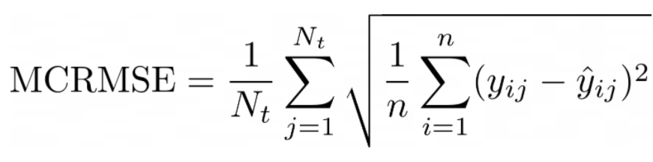

where is the number of scored ground truth target columns, and  and  are the actual and predicted values, respectively.

From the Data page: There are multiple ground truth values provided in the training data. While the submission format requires all 5 to be predicted, only the following are scored: reactivity, deg_Mg_pH10, and deg_Mg_50C.

In [ ]:
# source : https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [ ]:
# encode feature to import to model
def encoding(df, col):
  """
  df: dataframe containing sequences and the features
  col: column to apply encoding
      : valid values are: 'sequence', 'structure' and 'predicted_loop_type'
  """
  try:
    if col == 'sequence':
      seq_encoding = tokentoInt('AGCU')
      
    elif col == 'structure':
      seq_encoding = tokentoInt('(.)')

    elif col == 'predicted_loop_type':
      seq_encoding = tokentoInt("".join([x for x in loops.columns]))

    return np.array(df[col].apply(lambda seq: [seq_encoding[x] for x in seq]).values.tolist())

  except KeyError:
    print('Invalid arguments as col')

## Preparing Data to fit into our Model
- Sequence Model
- Structure Model
- Predicted Loop Type
- CNN model for BPPS files

In [ ]:
from tqdm import tqdm

So I plan to split the data like following:
- train: `train_data` and `valid_data` by filtering on SN_filer == 1
- test: `private_test` and `public_test` filtered on seq_length

In [ ]:
private_test = test.query("seq_length==130").copy()
public_test = test.query("seq_length==107").copy()

# this split on train set is applied if none of the cv folding aren't applied
train_data = train.query('SN_filter==0')
val_data = train.query('SN_filter==1')

### Features

In [ ]:
def get_features(df):
  seq_inp = encoding(df, 'sequence')
  struc_inp = encoding(df, 'structure')
  plt_inp = encoding(df, 'predicted_loop_type')
  '''
  bpps_arr = []
  for i in tqdm(range(len(df))):
    idx = df.loc[i]['id']
    bpps_arr.append(np.expand_dims(np.load(os.path.join(bpps_dir, str(idx)+'.npy')), axis=-1))

  cnn_inp = np.array(bpps_arr) # cnn data input
  '''
  return seq_inp, struc_inp, plt_inp #, cnn_inp

### Labels

In [ ]:
train_labels = np.array(train[target_cols].values.tolist()).transpose(0, 2, 1)
train_labels[0, 0, :]

In [ ]:
# setup seq_model include Input, embedding and LSTM layers.
def seq_model(encoding_dict,
              seq_len=107,
              pred_len=68,
              dropout=0.4,
              sp_dropout=0.2,
              embed_size=128,
              hidden_dim=256,
              layers=2,
              gru=False):
  
  # one sequence at a time of len 107 (if training specified)
  input = L.Input(shape=(seq_len, ))

  # apply embedding layer 
  embed = L.Embedding(input_dim=len(encoding_dict),
                      output_dim=embed_size)(input)

  '''reshaped = tf.reshape(embed,
                        shape=(-1, embed.shape[1], embed.shape[2] * embed.shape[3]))'''
  hidden = tf.keras.layers.SpatialDropout1D(sp_dropout)(embed)
  # apply bidirectional lstm/gru layers * layers count
  if gru:
    for _ in range(layers):
      hidden = gru_layer(hidden_dim, dropout)(hidden)
  else:
    for _ in range(layers):
      hidden = lstm_layer(hidden_dim, dropout)(hidden)
  
  return tf.keras.Model(input, hidden)
  pass

In [ ]:
'''
def cnn_model(input_shape=(107, 107), flag=False):
  """
  can be of shape 107*107(train and public set) and 130*130(private set) 
  """
  input = L.Input(shape=(*input_shape, 1))  # images are of 2-D

  # let's just go with 3 layers of CNN
  x = L.Conv2D(kernel_size=(5, 5),
               filters=64,
               strides=(2, 2))(input)
  x = L.MaxPool2D(pool_size=(2, 2))(x) # To get max value of feature and reduce parameter while training
  x = L.Activation('relu')(x) # I use activation function ReLu here

  x = L.Conv2D(kernel_size=(3, 3),
               filters=256)(x)
  x = L.MaxPool2D(pool_size=(2, 2))(x)
  x = L.Activation('relu')(x)
  
  x = L.Conv2D(kernel_size=(1, 4), filters=512)(x)
  x = L.Activation('relu')(x)
    
  # if there is flag, then add more layer
  if flag:
    x = L.Conv2D(kernel_size=(2, 2), filters=512)(x)
    x = L.Activation('relu')(x)
    x = tf.reshape(x, shape=(-1, x.shape[1]*x.shape[2], x.shape[-1], 1))
    return tf.keras.Model(input, x)

  x = tf.reshape(x, shape=(-1, x.shape[1]*x.shape[2], x.shape[-1], 1))
  x = L.Conv2D(kernel_size=(2, 1), filters=1)(x)
  x = L.Activation('relu')(x)




  return tf.keras.Model(input, x)
  pass
'''  

In [ ]:
# create model from 3 submodel seq_model
def main_model(seq_len=107, pred_len=68, cnn_input_shape=(107, 107), flag=False):
  """
  Consists of four models, one seq_model each for sequence, structure and predicted_loop
  and one CNN for BPPS files.
  """
  # extract from sequences
  Seq_model = seq_model(tokentoInt('AGCU'), seq_len=seq_len, pred_len=pred_len, dropout=0.0)
  Seq_op = Seq_model.output  # for train,  seq_len = 107

  Struct_model = seq_model(tokentoInt('(.)'), seq_len=seq_len, pred_len=pred_len, dropout=0.0)
  Struct_op = Struct_model.output

  PLT_model = seq_model(tokentoInt("".join([x for x in loops.columns])), seq_len=seq_len, pred_len=pred_len, dropout=0.0)
  PLT_op = PLT_model.output
  '''
  # add cnn layer output
  CNN_model = cnn_model(cnn_input_shape, flag=flag)
  CNN_op = CNN_model.output
  CNN_op = tf.reshape(CNN_op, shape=(-1, CNN_op.shape[1], CNN_op.shape[2] * CNN_op.shape[3]))
  
  print(Seq_op.shape, Struct_op.shape, PLT_op.shape, CNN_op.shape)
  '''
  # now we got 3 tensors of shape (BS, 107, 512)
  ip = tf.add_n([Seq_op, Struct_op, PLT_op])/3
  print(ip.shape)
  ip = ip[:, :pred_len]
  # Use core layer Dense
  ip = L.Dense(5, activation='linear')(ip)
  print(ip.shape)
  return tf.keras.Model(inputs=[Seq_model.input, Struct_model.input, PLT_model.input], outputs=ip)
  pass

In [ ]:
model = main_model()
model.summary()

In [ ]:
# Compile model with one of the most used optimizer Adam
model.compile(loss=MCRMSE,
           optimizer=tf.keras.optimizers.Adam(lr=0.005))

In [ ]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=5)
sv_lstm = tf.keras.callbacks.ModelCheckpoint(f'lstm.h5')

In [ ]:
model.fit(get_features(train), train_labels,
       epochs=75, batch_size=64,
       callbacks=[lr_callback, sv_lstm])

In [ ]:
model_long = main_model(seq_len=130, pred_len=130, cnn_input_shape=(130, 130), flag=True)
model_long.summary()

In [ ]:
model_long.load_weights('./lstm.h5')

In [ ]:
pred_long = model_long.predict(get_features(private_test), verbose=1)
pred_long.shape

In [ ]:
model_short = main_model(seq_len=107, pred_len=107, cnn_input_shape=(107, 107), flag=True)
model_short.summary()

In [ ]:
model_short.load_weights('./lstm.h5')
pred_short = model_short.predict(get_features(public_test), verbose=1)
pred_short.shape

In [ ]:
#create predict output data
def format_predictions(public_preds, private_preds):
    preds = []
    
    for df, preds_ in [(public_test, public_preds), (private_test, private_preds)]:
        for i, uid in enumerate(df.id):
            single_pred = preds_[i]

            single_df = pd.DataFrame(single_pred, columns=target_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

            preds.append(single_df)

    return pd.concat(preds).groupby('id_seqpos')

In [ ]:
df = format_predictions(pred_short, pred_long)
df.first()

In [ ]:
submission = df.sum().reset_index()
submission

In [ ]:
#extract result to submission.csv
submission.to_csv('submission.csv', index=False)